# Upwelling analysis

***

In [356]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import yaml
from cmocean import cm as cmocean
from matplotlib import cm, colors, lines, dates
from scipy import signal
from scipy.interpolate import griddata, interp1d
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
from dateutil.parser import parse
from contextlib import ExitStack
from salishsea_tools import viz_tools, geo_tools
import NEMO_upwelling_postprocessing as ps
from dynmodes import dynmodes

%matplotlib inline

In [455]:
# Increase plot font size
plt.rcParams['font.size'] = 13

***

## Load variables

In [599]:
# ------- Load variables -----------

# NetCDF objects
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
bathy = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc')
grid_HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')

# Upwelling events
events = {}
with open('parameters.yaml') as fn: events['N'], events['S'] = yaml.safe_load_all(fn)

# Idealized parameters
params = {
    'u_wind': [5, 10, 15],
    'h_s': [10, 15, 20],
    'rho_s': [1016, 1018, 1020],
    'N': np.arange(0.01, 0.026, 0.0025),
}

# Constants
const = {
    'g': 9.81, 'f': 1.11e-4, 'N': 0.01, 'h_s': 10, 'H': 50, 'L_r': 1e4, 't': 86400,
    'rho_0': 1025, 'rho_s': 1020, 'rho_air': 1.23, 'C_d': 1e-3,
}

# Subdomains
#subdomains = {
#    'ideal': [114, 398, 334, 898],
#    'NO3': [115, 360, 310, 788],
#}

## Processing

***

In [250]:
# Initialize dict
sections, runs = {}, {}

# Loop through coasts
for coast in ['S', 'N']:
    
    # Initialize sub dict
    runs[coast] = {}

    # Sections
    sections[coast] = ps.calc_coastline_indices(mask, bathy.Bathymetry.values, grid_HRDPS, const, coast=coast)

    # Idealized
    runs[coast]['idealized'] = ps.load_idealized(params, sections[coast], mask, const, coast=coast)
    runs[coast]['idealized'] = ps.calc_predictions(runs[coast]['idealized'], const, tscale='Choboter', mixing=False)

    # Hindcast
    runs[coast]['hindcast'] = ps.load_hindcast(events[coast], sections[coast], mask, const, HRDPS=HRDPS, coast=coast)
    runs[coast]['hindcast'] = ps.calc_predictions(runs[coast]['hindcast'], const, tscale='Choboter', mixing=False)

/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:74: RuntimeWarning: invalid value encountered in greater
  index = np.array([bathy[y, x] for y, x in zip(j_s, i_s)]) > const['H']


/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:395: RuntimeWarning: invalid value encountered in log
  T_u = np.log((np.cos(2 * mu * runs['h_s'] / const['H']) - 1) / S_ratio + 1) / (2 * mu) + const['t'] / runs['T_d']
/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:74: RuntimeWarning: invalid value encountered in greater
  index = np.array([bathy[y, x] for y, x in zip(j_s, i_s)]) > const['H']
/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:77: RuntimeWarning: divide by zero encountered in double_scalars
  s = const['H'] / np.sqrt(((i_d - i) * e1t)**2 + ((j_d - j) * e2t)**2)


/ocean/bmoorema/research/MEOPAR/SOG_upwelling_paper/notebooks/NEMO_upwelling_postprocessing.py:395: RuntimeWarning: invalid value encountered in log
  T_u = np.log((np.cos(2 * mu * runs['h_s'] / const['H']) - 1) / S_ratio + 1) / (2 * mu) + const['t'] / runs['T_d']


***

## Results

### Plotting functions

In [643]:
def calc_pycnocline(N2, deptht):
    """
    """
    
    h_s, N2 = [], np.nanmedian(N2, axis=2)
    for n2 in N2:
        _, _, rmode, _ = dynmodes(n2, deptht, 1)
        h_s.append(deptht[int(abs(rmode[0, :]).argmax())])
    
    return np.array(h_s)


def calc_timeseries():
    """
    """

    # Define mask arrays
    deptht, depthw, tmask, e1t, e3t = [mask[key][0, ...].values for key in ['gdept_1d', 'gdepw_1d', 'tmask', 'e1t', 'e3t_1d']]
    timeseries = {}

    # Loop through coasts
    for coast in ['S', 'N']:

        # Loop through first 5 events
        for event in events[coast][1:2]:

            # Parse info
            event = parse(event)
            timeseries[event] = {'HRDPS': {'tau': {}}, 'NEMO': {'h_s_avg': {}, 'h_s': {}, 'h_u': {}}}
            timerange = [event + timedelta(hours=h) for h in [-12, 60]]
            days = np.diff(timerange)[0].days + 1

            # Store time arrays
            timeseries[event]['HRDPS']['time'] = \
                HRDPS.time.sel(time=slice(*timerange)).values.astype('datetime64[s]').astype(datetime)
            timeseries[event]['NEMO']['time'] = \
                np.array([timerange[0].replace(hour=0) + timedelta(hours=h) for h in range(24*days)])
            
            # Starting index
            istart = abs(timeseries[event]['NEMO']['time'] - event).argmin()
            
            # Open NEMO files
            data, findex = [], []
            with ExitStack() as stack:
                for d in range(days):
                    date = timerange[0] + timedelta(days=d)
                    data.append(stack.enter_context(xr.open_dataset(ps.make_prefix(date) + '_grid_T.nc')))

                # Loop through sections
                for a, j, i, jw, iw in zip(
                    tqdm(sections[coast]['angle'][::10], desc=f"Loading {event.strftime('%Y-%b-%d')}"),
                    *[sections[coast]['ji'][col][::10] for col in [0, 1]],
                    *[sections[coast]['ji_wind'][col][::10] for col in [0, 1]],
                ):
                    
                    # Calc wind stress
                    L = int(const['L_r'] / 2.5e3)
                    if coast == 'N': slc = slice(iw-L, iw)
                    elif coast == 'S': slc = slice(iw, iw+L)
                    u, v = [
                        HRDPS[k].sel(time=slice(*timerange)).isel(gridY=jw, gridX=slc).values
                        for k in ['u_wind', 'v_wind']
                    ]
                    tau = 1.225e-3 * np.sqrt(u**2 + v**2)**2
                    angle = np.arctan2(v, u) - np.pi * (29 / 180) + a
                    timeseries[event]['HRDPS']['tau'][j] = (np.sin(angle) * tau).mean(axis=1)

                    # Calc rho
                    if coast == 'S':
                        L = np.where(tmask[0, j, i:] == 0)[0][1]
                        slc = slice(i, i+L)
                    elif coast == 'N':
                        L = i - np.where(tmask[0, j, :i] == 0)[0][-1]
                        slc = slice(i-L, i)
                    tmask_brdcst = np.broadcast_to(tmask[:, j, slc], (24, 40, L))
                    deptht_brdcst = deptht[np.newaxis, :, np.newaxis]
                    rho = np.vstack(
                        [ps.calc_rho(ds.isel(y=j, x=slc), deptht_brdcst, tmask_brdcst) for ds in data],
                    )
                    
                    # Calc N2
                    interp_rho = interp1d(deptht, rho, axis=1, fill_value='extrapolate')
                    N2 = const['g'] / const['rho_0'] * np.diff(interp_rho(depthw), axis=1) / e3t[np.newaxis, :-1, np.newaxis]
                    nanindex = np.where(np.all(tmask[:, j, slc] == 0, axis=1))[0][0] - 1
                    timeseries[event]['NEMO']['h_s_avg'][j] = calc_pycnocline(N2[:, :nanindex, :], deptht[:nanindex])
                    
                    # Calc pycnocline and upwelling depth
                    L = int(const['L_r'] / e1t[j, i])
                    if coast == 'S':
                        slc = slice(1, L)
                        nanindex = np.where(np.all(tmask[:, j, slice(i, i+L)] == 0, axis=1))[0][0] - 1
                    elif coast == 'N':
                        slc = slice(2-L, None)
                        nanindex = np.where(np.all(tmask[:, j, slice(i-L, i)] == 0, axis=1))[0][0] - 1
                    timeseries[event]['NEMO']['h_s'][j] = calc_pycnocline(N2[:, :nanindex, slc], deptht[:nanindex])
                    deltarho = rho[istart, np.newaxis, :nanindex, slc] - np.nanmax(rho[:, 0, slc], axis=1)[:, np.newaxis, np.newaxis]
                    timeseries[event]['NEMO']['h_u'][j] = np.array(
                        [deptht[int(z)] for z in np.nanmedian(np.nanargmin(abs(deltarho), axis=1), axis=1)],
                    )

    return timeseries


def plot_timeseries(timeseries):
    """
    """

    # Make figure
    N = 3
    fig, axs = plt.subplots(N*2, 2, figsize=(15, 12), gridspec_kw={'wspace': 0.1})
    cmap = plt.get_cmap('copper')
    ylims, ylabels = [(-0.28, 0.28), (40, 0)], ['$\\tau_{along}$ [N m$^{-2}$]', '$h_u$ [m]']

    # Loop through coasts
    for k, col, coast, titlestr in zip(range(2), axs.T, ['S', 'N'], ['Southerly', 'Northerly']):
        
        col[0].set_title(f'{titlestr} wind', size=12)

        # Loop through first 5 events
        for count, panel, event in zip(range(3), [col[n:n+2] for n in range(0, N*2, 2)], events[coast][:N]):

            # Parse info
            event = parse(event)
            timerange = [event + timedelta(hours=h) for h in [-12, 60]]
            jmin, jmax = [getattr(sections[coast]['ji'][0], attr)() for attr in ['min', 'max']]
            jdelta = jmax - jmin
            
            # Preliminary plot formatting
            panel[0].plot(timerange, [0, 0], 'k:')
            panel[0].xaxis.set_ticks([])
            panel[0].xaxis.set_ticklabels('')
            panel[0].text(0.015, 0.85, f'({chr(97+2*count+k)})', transform=panel[0].transAxes)
            panel[1].set_facecolor([0.9, 0.9, 0.9])
            for ax, ylim, ylabel in zip(panel, ylims, ylabels):
                ax.plot([event, event], ylim, 'r--')
                ax.set_xlim(timerange)
                ax.set_ylim(ylim)
                ax.xaxis.set_major_locator(dates.DayLocator())
                ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%d'))
                if coast == 'S': ax.set_ylabel(ylabel)
                else: ax.yaxis.set_ticklabels('')
            count += 1
                
            pos = panel[1].get_position().get_points().flatten()
            deltax, deltay = [pos[k+2] - pos[k] for k in range(2)]
            x, y = pos[0], panel[0].get_position().get_points().flatten()[1] - deltay
            panel[1].set_position([x, y, deltax, deltay])

            # Loop through sections
            for j in sections[coast]['ji'][0][::10]:
                for ax, key, var, linestyle in zip(panel, ['HRDPS', 'NEMO'], ['tau', 'h_u'], ['-', '--']):
                    ax.plot(
                        timeseries[event][key]['time'], timeseries[event][key][var][j],
                        color=cmap((j - jmin)/jdelta), linestyle=linestyle,
                    )

    # Colorbar
    cax = fig.add_axes([0.92, 0.16, 0.01, 0.7])
    fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=jmin, vmax=jmax), cmap=cmap), cax=cax, label='Model grid Y')
    
    return fig, ax


def plot_results(normkeys, lims):
    """
    """
    
    # Make figure panel
    fig, axs = plt.subplots(4, 2, figsize=(10, 18), gridspec_kw={'wspace': 0.1})
    fig.add_artist(lines.Line2D([0.08, 0.92], [0.5, 0.5], linestyle='-', color='k'))

    # KDE parameters
    n, lim, levels, bandwidth = 50, 1, np.array([1, 4, 7, 10]), 0.02
    
    # Loop through coastlines
    for k, col, config in zip(range(2), axs.T, ['idealized', 'hindcast']):
        
        col[0].set_title(config.capitalize(), size=12)
        
        # Loop through parameters
        count = 0
        for panels, key, normkey, lim in zip([col[:2], col[2:]], ['h_u', 'x_u'], normkeys, lims):

            # Loop through rows
            for ax, coast, label in zip(panels, ['S', 'N'], ['Southerly', 'Northerly']):

                # Plot data
                x = runs[coast][config][key+'_pred'] / runs[coast][config][normkey]
                y = runs[coast][config][key] / runs[coast][config][normkey]
                ax.plot(x, y, 'o', color='lightgray')

                # Plot KDE
                index = (runs[coast][config][key] > 0) & ~np.isnan(runs[coast][config][key+'_pred'])
                grid = np.linspace(0, lim, n)
                xy_data = np.vstack([x[index], y[index]]).T
                xy_grid = np.vstack([dim.ravel() for dim in np.meshgrid(grid, grid)]).T
                kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth*lim)
                z = np.exp(kde.fit(xy_data).score_samples(xy_grid)).reshape((n, n))
                ax.contour(grid, grid, z, levels=levels/lim**2, zorder=10)

                # Formatting
                ax.plot([0, lim], [0, lim], 'k--')
                ax.set_xlim([0, lim])
                ax.set_ylim([0, lim])
                ax.text(0.02, 0.92, f'({chr(97+count+k)})', transform=ax.transAxes)
                if config == 'idealized':
                    ax.set_ylabel(f'${key}/{normkey}$ (calculated)')
                    ax.text(0.1, 0.92, label + ' wind', transform=ax.transAxes)
                else: ax.yaxis.set_ticklabels('')
                count += 2
                
            # Formatting
            pos = panels[1].get_position().get_points().flatten()
            panels[1].set_position([pos[0], pos[1]+0.02, pos[2]-pos[0], pos[3]-pos[1]])
            panels[1].set_xlabel(f'${key}/{normkey}$ (predicted)')
            panels[0].xaxis.set_ticklabels('')
            
    return fig, axs


def plot_spatial(config='hindcast'):
    """
    """
    
    # Make figure area
    fig, axs = plt.subplots(2, 4, figsize=(17, 15), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    
    # Loop through coasts
    count = 0
    for row, coast, label in zip(axs, ['S', 'N'], ['Southerly', 'Northerly']):

        # Plot map and bathymetry
        row[0].contourf(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='gray')
        row[0].contour(mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        row[0].contourf(bathy.Bathymetry, levels=range(0, 500, 50), cmap=cmocean.deep)
        row[0].plot(*sections[coast]['ji'][::-1], 'mo')
        row[0].set_xlim([115, 320])
        row[0].set_ylim([360, 740])
        row[0].set_ylabel('Grid y')
        viz_tools.set_aspect(row[0])
        row[1].text(0.2, 0.96, label + ' wind', transform=row[1].transAxes)
        row[0].text(0.86, 0.96, f'({chr(97+count)})', transform=row[0].transAxes, bbox=dict(facecolor='w'))
        if coast == 'N': row[0].set_xlabel('Grid x')
        else: row[0].xaxis.set_ticklabels('')
        count += 1

        # Plot upwelling diagnostics
        xlims = [(-0.01, 0.16), (0.004, 0.0499), (0, 0.8)]
        xlabels = ['$\\tau_{along}$ [N m$^{-2}$]', '$N$ [s$^{-1}$]', '$h_u/H$ (predicted)']
        for ax, key, norm, xlim, xlabel in zip(row[1:], ['tau_along', 'N', 'h_u_pred'], [1, 1, const['H']], xlims, xlabels):
            c = ax.scatter(
                runs[coast][config][key]/norm, runs[coast][config]['j'],
                s=50, c=runs[coast][config]['h_u']/const['H'],
                vmin=0, vmax=0.8, cmap='RdBu_r',
            )
            ax.set_xlim(xlim)
            ax.set_ylim([360, 740])
            ax.yaxis.set_ticklabels('')
            ax.text(0.025, 0.96, f'({chr(97+count)})', transform=ax.transAxes)
            if coast == 'N': ax.set_xlabel(xlabel)
            else: ax.xaxis.set_ticklabels('')
            count += 1

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='$h_u/H$ (calculated)')
        
    return fig, axs


def plot_property_space():
    """
    """
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 12), gridspec_kw={'hspace': 0.1, 'wspace': 0.1})
    cmap = plt.get_cmap('RdBu_r')

    # Build predicted contours
    S, tT = np.meshgrid(np.arange(0.1, 15.1, 0.1), np.arange(0, 1.01, 0.01))                                                                                                 
    exp = 1 - np.exp(-2 * np.arctan(S) * tT)
    h_u = np.arccos(1 - 2 * S**2 / (1 + S**2) * exp) / (2 * np.arctan(S))

    # Plot run results
    count = 0
    for row, coast, label in zip(axs, ['S', 'N'], ['Southerly', 'Northerly']):
        row[0].text(0.6, 0.94, label + ' wind', transform=row[0].transAxes)
        for ax, config in zip(row, ['idealized', 'hindcast']):
            ax.contour(S, tT, h_u, levels=np.arange(0, 0.81, 0.05), cmap=cmap)
            c = ax.scatter(
                runs[coast][config]['S'], const['t']/runs[coast][config]['T_d'],
                s=50, c=runs[coast][config]['h_u']/const['H'], cmap=cmap, vmin=0, vmax=0.8,
            )
            ax.set_xlim([0.5, 15])
            ax.set_ylim([0, 0.63])
            ax.text(0.92, 0.94, f'({chr(97+count)})', transform=ax.transAxes)
            if coast == 'N': ax.set_xlabel('$H_xN/f$')
            else:
                ax.xaxis.set_ticklabels('')
                ax.set_title(config.capitalize(), size=12)
            if config == 'idealized': ax.set_ylabel('$t/T$')
            else: ax.yaxis.set_ticklabels('')
            count += 1

    # Add colorbar
    cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
    fig.colorbar(c, cax=cax, label='$h_u/H$ (calculated)')
    
    return fig, axs

***

### Figures

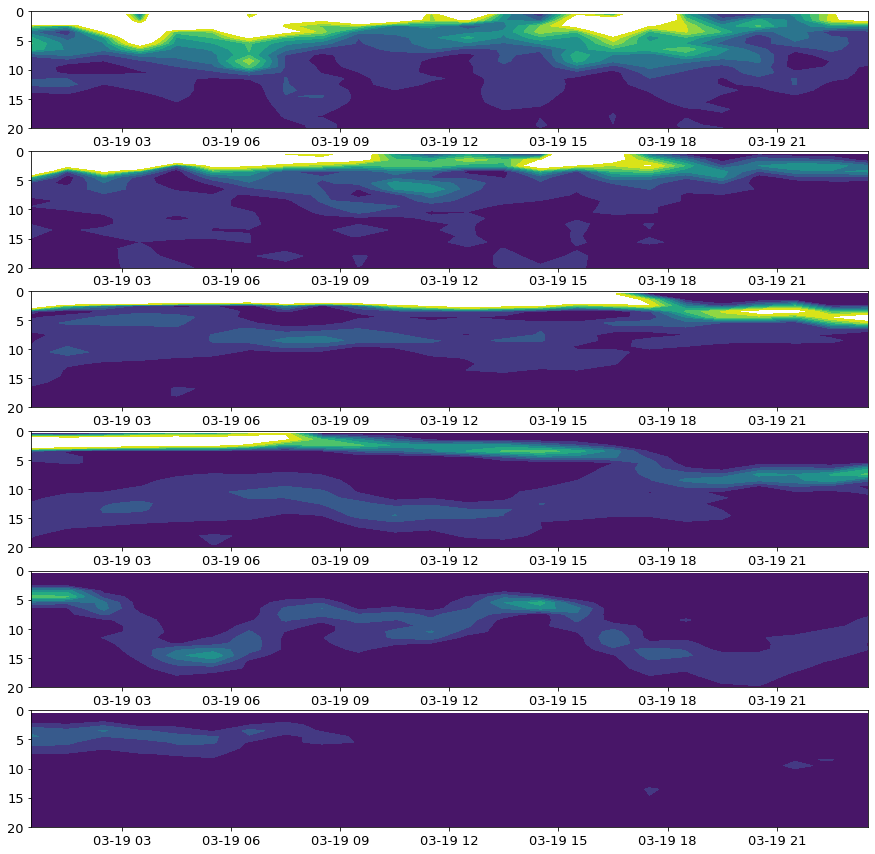

In [701]:
fig, axs = plt.subplots(6, 1, figsize=(15, 15))

fn = ps.make_prefix(parse(events['S'][1])+timedelta(days=1)) + '_grid_T.nc'
with xr.open_dataset(fn) as ds:
    
    for ax, j, i in zip(tqdm(axs), *[sections['S']['ji'][col][::10] for col in [0, 1]]):
        tmask_brdcst = np.broadcast_to(tmask[:, j, i+5], (24, 40))
        deptht_brdcst = deptht[np.newaxis, :]
        rho = ps.calc_rho(ds.isel(y=j, x=i+5), deptht_brdcst, tmask_brdcst)
        interp_rho = interp1d(deptht, rho, axis=1, fill_value='extrapolate')
        N2 = const['g'] / const['rho_0'] * np.diff(interp_rho(depthw), axis=1) / e3t[np.newaxis, :-1]
        ax.contourf(ds.time_counter, deptht[:-1], N2.T, levels=np.arange(0, 0.005, 0.0005))
        ax.set_ylim([20, 0])

In [644]:
# Plot wind events
timeseries = calc_timeseries()

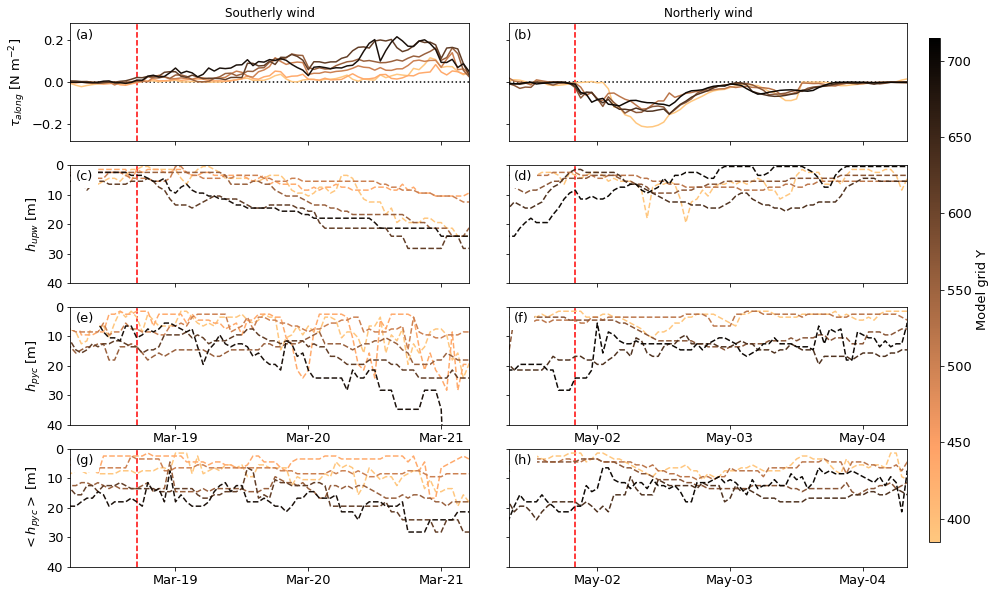

In [647]:
# Make figure
fig, axs = plt.subplots(4, 2, figsize=(15, 10), gridspec_kw={'wspace': 0.1})
cmap = plt.get_cmap('copper_r')
ylims, ylabels = [(-0.28, 0.28), (40, 0), (40, 0), (40, 0)], ['$\\tau_{along}$ [N m$^{-2}$]', '$h_{upw}$ [m]', '$h_{pyc}$ [m]', '$<h_{pyc}>$ [m]']

# Loop through coasts
for col, panel, coast, titlestr in zip(range(2), axs.T, ['S', 'N'], ['Southerly', 'Northerly']):
    
    panel[0].set_title(f'{titlestr} wind', size=12)

    # Parse info
    event = parse(events[coast][1])
    timerange = [event + timedelta(hours=h) for h in [-12, 60]]
    jmin, jmax = [getattr(sections[coast]['ji'][0], attr)() for attr in ['min', 'max']]
    jdelta = jmax - jmin

    # Preliminary plot formatting
    panel[0].plot(timerange, [0, 0], 'k:')
    panel[0].xaxis.set_ticks([])
    panel[0].xaxis.set_ticklabels('')
    for n, ax, ylim, ylabel in zip(range(4), panel, ylims, ylabels):
        ax.plot([event, event], ylim, 'r--')
        ax.set_xlim(timerange)
        ax.set_ylim(ylim)
        ax.xaxis.set_major_locator(dates.DayLocator())
        ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%d'))
        ax.text(0.013, 0.87, f'({chr(97+n*2+col)})', transform=ax.transAxes, bbox={'facecolor': 'w', 'edgecolor': 'w'})
        if coast == 'S': ax.set_ylabel(ylabel)
        else: ax.yaxis.set_ticklabels('')
        if n < 2: ax.xaxis.set_ticklabels('')

    # Loop through sections
    for j in sections[coast]['ji'][0][::10]:
        for ax, key, var, linestyle in zip(panel, ['HRDPS', 'NEMO', 'NEMO', 'NEMO'], ['tau', 'h_u', 'h_s', 'h_s_avg'], ['-', '--', '--', '--']):
            ax.plot(
                timeseries[event][key]['time'], timeseries[event][key][var][j],
                color=cmap((j - jmin)/jdelta), linestyle=linestyle,
            )
            
cax = fig.add_axes([0.92, 0.16, 0.01, 0.7])
fig.colorbar(cm.ScalarMappable(norm=colors.Normalize(vmin=jmin, vmax=jmax), cmap=cmap), cax=cax, label='Model grid Y')

#fig.savefig('/home/bmoorema/Desktop/figs_2020/mixing_vs_upwelling.pdf', bbox_inches='tight')

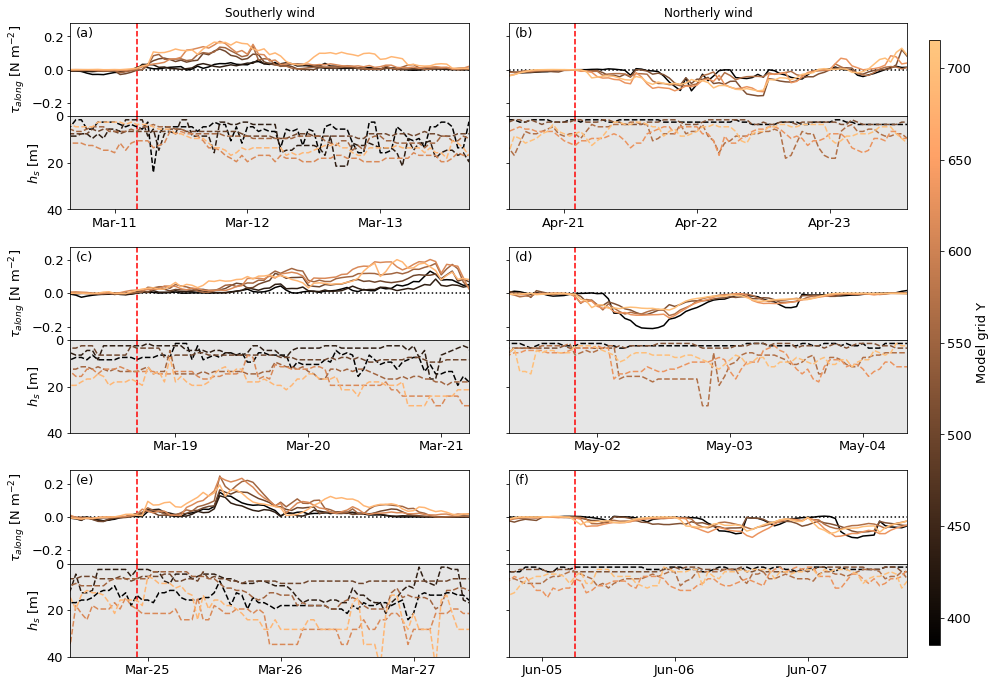

In [458]:
fig, axs = plot_timeseries(timeseries)
#fig.savefig('/home/bmoorema/Desktop/figs_2020/event_timeseries_pycno.pdf', bbox_inches='tight')

***

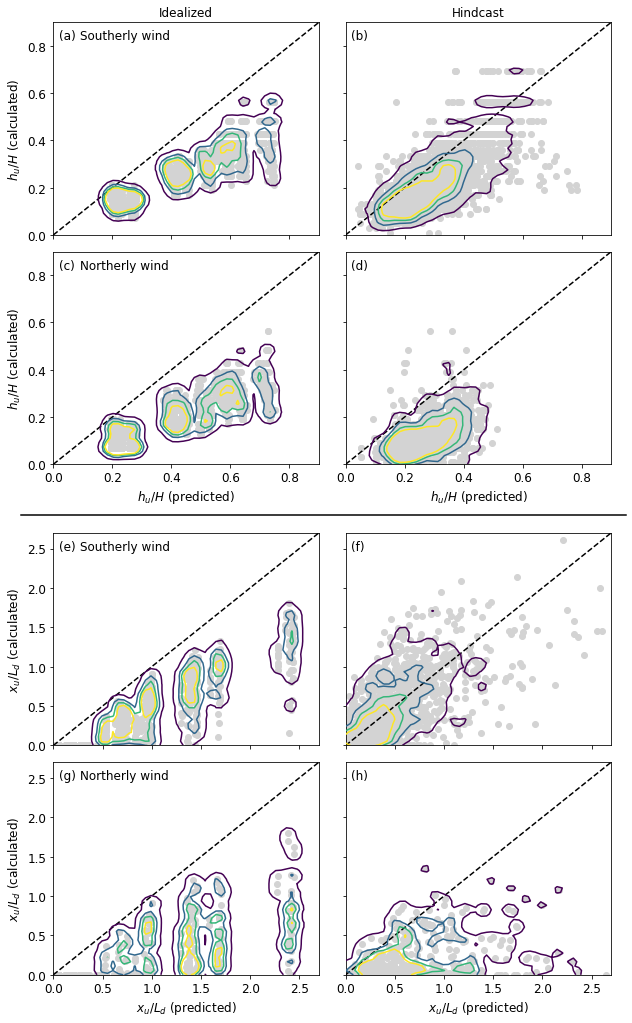

In [260]:
# Plot basic
fig, axs = plot_results(['H', 'L_d'], [0.9, 2.7])
fig.savefig('/home/bmoorema/Desktop/figs_2020/results_basic.pdf', bbox_inches='tight')

***

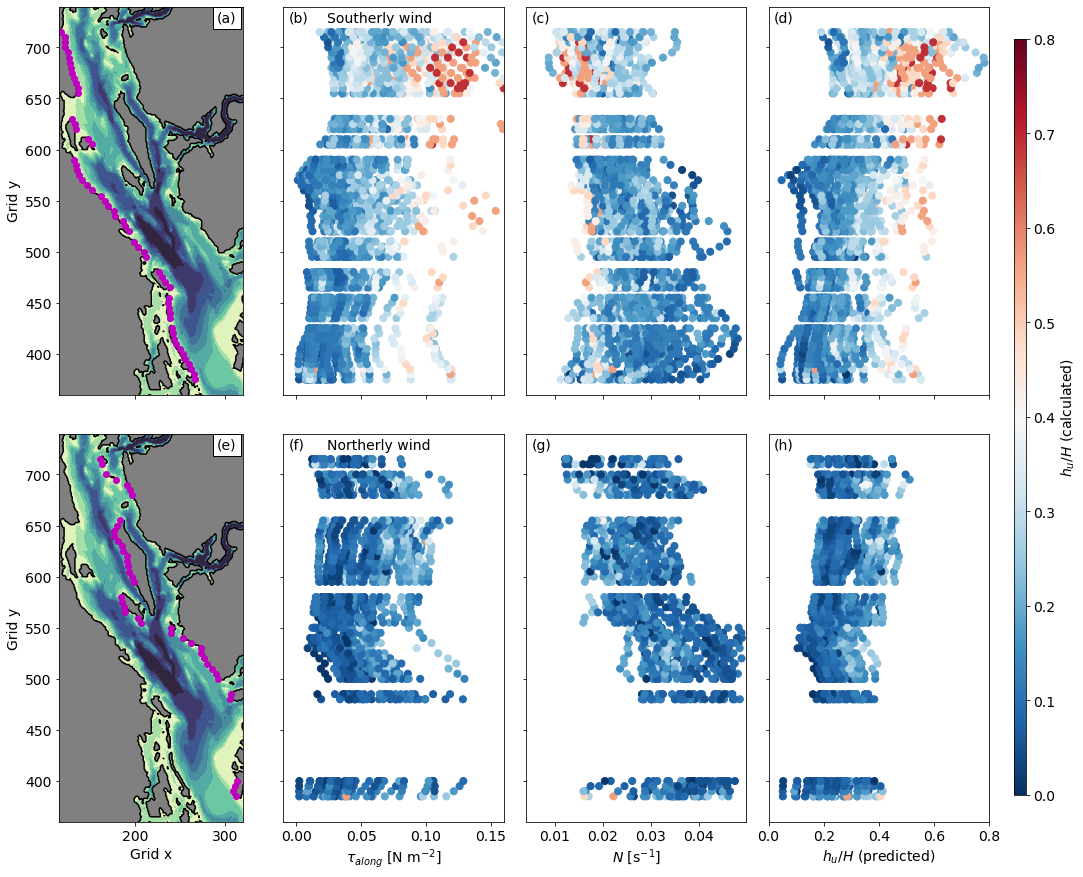

In [282]:
# Plot spatial
fig, axs = plot_spatial()
fig.savefig('/home/bmoorema/Desktop/figs_2020/results_spatial.pdf', bbox_inches='tight')

***

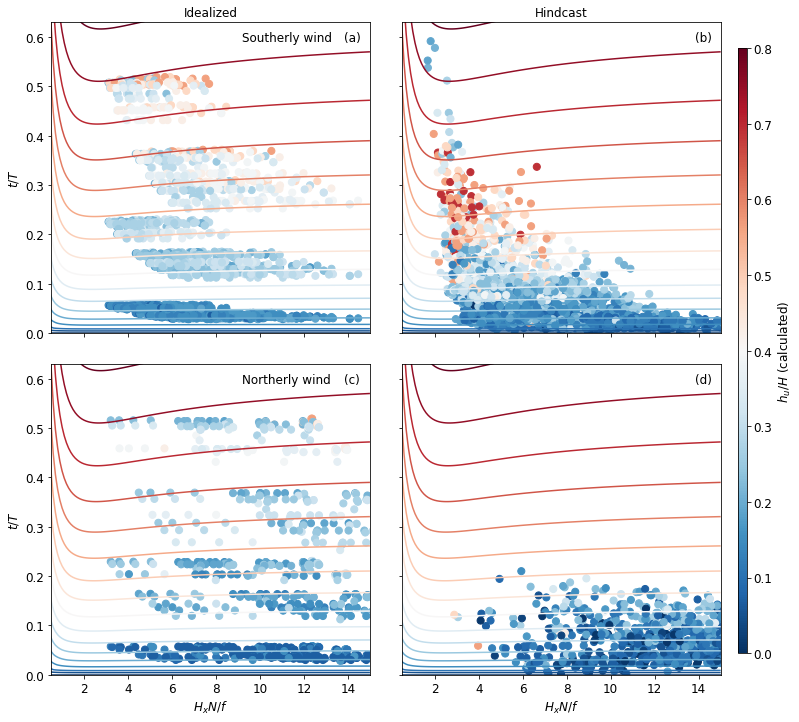

In [278]:
# Plot property space
fig, axs = plot_property_space()
fig.savefig('/home/bmoorema/Desktop/figs_2020/results_property.pdf', bbox_inches='tight')